<a href="https://colab.research.google.com/github/jonbmartin/Gradient-Waveform-Errors-Demos/blob/main/Ex2_GIRF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks through building a gradient impulse response function (GIRF) and applying the GIRF model to predict distortions in gradient waveforms.

This demo minimally adapts MATLAB code created by Johanna Vannesjo and Lars Kasper, two of the GIRF method authors (see https://github.com/MRI-gradient/GIRF for their implementation).

See this list of references:


In [1]:
!git clone https://github.com/jonbmartin/Gradient-Waveform-Errors-Demos

import sys
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos')
sys.path.insert(0,'/content/Gradient-Waveform-Errors-Demos/utils/')
from waveforms import *

import numpy as np
import pulpy.grad as pulpgrad
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, fftfreq, fftshift

fatal: destination path 'Gradient-Waveform-Errors-Demos' already exists and is not an empty directory.


/usr/local/lib/python3.11/dist-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


Ok, next let us build some test waveforms to build/evaluate the GIRF. We will construct a simple chirp waveform and a standard blip gradient.

In [10]:
# --- Define Chirp Parameters ---
N = 1020       # Number of points
dt = 0.01      # Timestep (ms) -> 10 ms total duration
G1 = 1        # Max gradient (G/cm)
f1 = 0.5       # Start frequency (kHz)
f2 = 5.0       # End frequency (kHz)
slr = 6      # Slew rate limit (G/cm/ms)

# --- Generate and Plot the Chirp ---
# We plot the slew rate to verify that we are indeed getting a slew-constrained
# chirp waveform.
chirp_waveform_slr, slr_time_vector = chirp_slew_constrained(N, dt, G1, f1, f2, slr)
chirp_waveform_slr = chirp_waveform_slr/np.max(np.abs(chirp_waveform_slr))
slr_time_vector = slr_time_vector/1000 # [s]
# chirp_waveform = chirp_waveform[:,None]

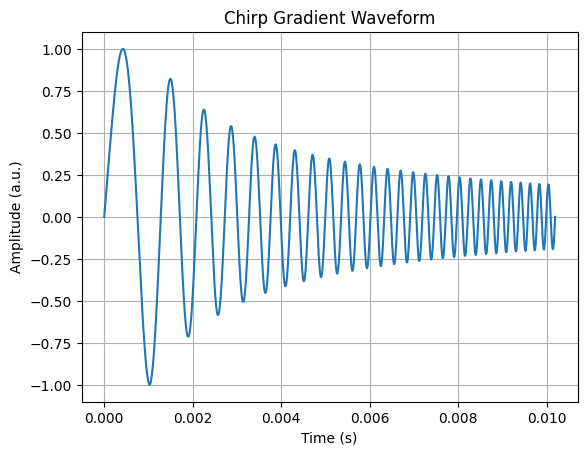

In [11]:
# Plot the chirp waveform
plt.plot(slr_time_vector, chirp_waveform_slr)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (a.u.)')
plt.title('Chirp Gradient Waveform')
plt.grid(True)
plt.show()

Ok, next we simulate a very simple gradient hardware system. Let's say that our hardware just low-pass filters our input - a fairly realistic, linear distortion.

While not strictly necessary for this example, but we will form a library of two input/output waveform pairs (one a scaled version of the other) to demonstrate the process for multiple measurements.

In [17]:
inTime = np.pad(chirp_waveform_slr,(500,500))
inTime = inTime[:,None]
inTime = np.stack((inTime, inTime/2, ), axis=1)
inTime = np.squeeze(inTime)
print(np.shape(inTime))
n_waveforms = np.shape(inTime)[1]

inFreq = np.zeros(np.shape(inTime), dtype=complex)
outTime = np.zeros(np.shape(inTime), dtype=complex)
outFreq = np.zeros(np.shape(inTime), dtype=complex)

thresh = 6E3 # [Hz]

for ii in range(n_waveforms):
  signal = inTime[:,ii]
  W = fftfreq(signal.size, d=slr_time_vector[1]-slr_time_vector[0])
  inFreq[:,ii] = fft(signal)

  cut_f_signal = inFreq[:,ii].copy()
  cut_f_signal[(abs(W)<thresh)] = cut_f_signal[(abs(W)<thresh)] * (1-abs(W[(abs(W)<thresh)])/thresh)
  cut_f_signal[(abs(W)>thresh)] = 0
  outFreq[:,ii] = cut_f_signal

  cut_signal = ifft(cut_f_signal)
  outTime[:,ii] = cut_signal

(2020, 2)


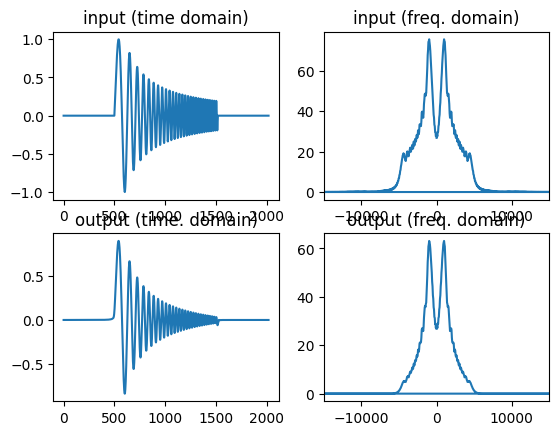

In [18]:
plt_idx = 0

plt.subplot(221)
plt.plot(inTime[:,plt_idx])
plt.title('input (time domain)')

plt.subplot(222)
plt.plot(W,np.abs(inFreq[:,plt_idx]))
plt.title('input (freq. domain)')
plt.xlim(-1.5E4,1.5E4)

plt.subplot(224)
plt.plot(W,np.abs(outFreq[:,plt_idx]))
plt.title('output (freq. domain)')
plt.xlim(-1.5E4,1.5E4)

plt.subplot(223)
plt.plot(outTime[:,plt_idx])
plt.title('output (time. domain)')
plt.show()


Next, we compute the GIRF:


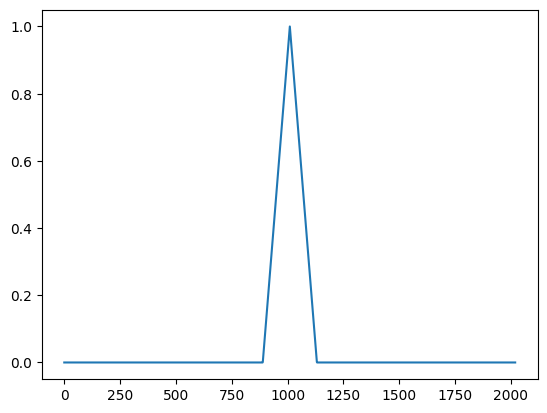

In [14]:
inFreq = np.fft.fftshift(inFreq, axes=0)
outFreq = np.fft.fftshift(outFreq, axes=0)

# perform least-squares estimation from the input
inSOSInv = 1/(np.sum(np.abs(inFreq)**2,axis=1))

girf = np.sum(outFreq*np.conj(inFreq),axis=1)*inSOSInv
girf = girf / np.max(np.abs(girf))

plt.plot(np.abs(girf))
plt.show()

Test the predictive power of our GIRF! We'll perform a frequency-domain application.

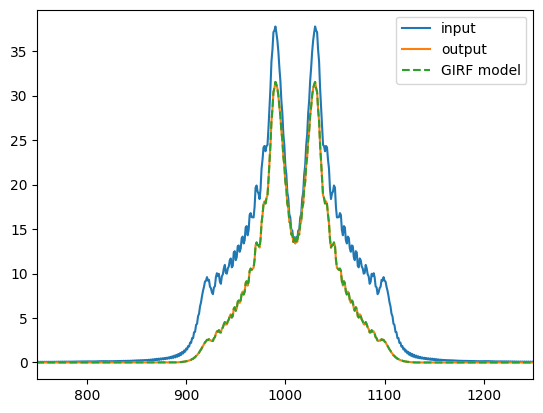

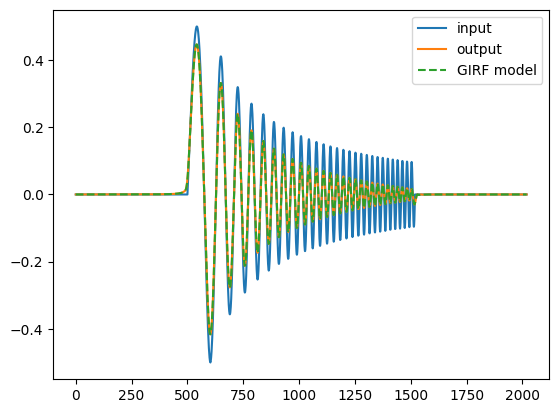

In [15]:
H = girf

out_pred = np.zeros(np.shape(inFreq), dtype=complex)
for ii in range(n_waveforms):
  out_pred[:,ii] = H * inFreq[:,ii]

plot_idx = 1
plt.plot(np.abs((inFreq[:,plot_idx])))
plt.plot(np.abs((outFreq[:,plot_idx])))
plt.plot(np.abs((out_pred[:,plot_idx])),'--')
plt.xlim(750,1250)
plt.legend(['input', 'output', 'GIRF model'])
plt.show()

plt.plot(inTime[:,plot_idx])
plt.plot(np.real(ifft(fftshift(out_pred[:,plot_idx]))))
plt.plot(outTime[:,plot_idx],'--')
plt.legend(['input', 'output', 'GIRF model'])
plt.show()
